In [ ]:
# encoding=utf8

# Linear Regression Analysis

Deriving Errors: An Example with Linear Regression

In [1]:
# only necessary if you're running Python 2.7 or lower
from __future__ import print_function
from builtins import range

# import matplotlib and define our alias
from matplotlib import pyplot as plt

# plot figures within the notebook rather than externally
%matplotlib inline

# numpy
import numpy as np

# scipy 
import scipy

# Setup

Our original statistical model looked like this:

$$ x_i \sim \textrm{Unif}(-6, -4) $$
$$ \epsilon_i \sim \textrm{Normal}(\mu=0, \sigma=0.3) $$
$$ y_i = -2.43x_i - 4.05 + \epsilon_i $$

where the index $i$ just is telling us we observed this quantity for object $i$. Here, we assume that our $x_i$'s are error-free (that we can essentially measure them perfectly), and treat our observations as having errors $\epsilon_i$'s.

In [2]:
# define the linear relationship between x and y
def yfunc(x):
    return -4.05 - 2.43 * x 
theta_true = [-4.05, -2.43]

In [3]:
# generate random data points from the cepheid period-luminosity relationship
n = 10  # number of objects
sigma = 0.3  # intrinsic scatter

x = np.random.uniform(-6, -4., n)  # x's
y = yfunc(x)  # y's
e = np.random.normal(0.0, sigma, n)  # errors
yobs = y + e  # *observed* y's

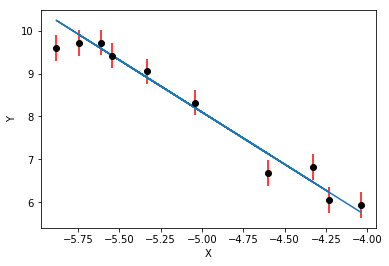

In [4]:
# plotting results
plt.plot(x, y)  # linear relationship
plt.errorbar(x, yobs, yerr=sigma, fmt='ko', ecolor='red')  # observed data
plt.xlabel('X')
plt.ylabel('Y')

# Maximum a Posteriori (MAP) Analysis

Using the notation from the previous notebook, we can write Bayes' Theorem as

$$ P(\alpha, \beta \,|\, \mathbf{y}) = \frac{P(\mathbf{y} \,|\, \alpha, \beta) \, P(\alpha, \beta)}{P(\mathbf{y})} \propto P(\mathbf{y} \,|\, \alpha, \beta) \, P(\alpha, \beta) $$

where $P(\alpha, \beta)$ is the **prior** on $\alpha$ and $\beta$, $P(\mathbf{y} \,|\, \alpha, \beta)$ is the **likelihood** of $\mathbf{y}$ given $\alpha$ and $\beta$, $P(\mathbf{y})$ is the **evidence** for $\mathbf{y}$ over all possible $\alpha$ and $\beta$, and $P(\alpha, \beta \,|\, \mathbf{y})$ is the posterior (what we're usually interested in) for $\alpha$ and $\beta$ given $\mathbf{y}$. We will again ignore the evidence since it's just a normalization constant here.

In the previous notebook, we showed that **least-squares** minimization, **$\chi^2$** minimization, and **maximum-likelihood** analyses are all fundamentally equivalent in our problem and give us exactly the same solution. We also pointed out that this result extends to our posterior as well, *as long as our prior is uniform everywhere*. In other words, if $P(\alpha, \beta) = 1$, then maximum-likelihood analyses are also identical to **maximum a posteriori (MAP)** analyses.

For a given $\alpha$ and $\beta$, we expect that our residuals $\Delta y_i$ should follow the same distribution as our noise $\epsilon_i$ (i.e. normally distributed with mean $\mu=0$ and standard deviation $\sigma=0.3$). The probability of observing residual $\Delta y_i$ conditioned on our model parameters $\alpha$ and $\beta$ (i.e. the likelihood) is then

$$ P(\Delta y_i \,|\, \alpha, \beta) = \frac{1}{\sigma\sqrt{2\pi}} \exp \left[ - \frac{(\Delta y_i)^2}{2\sigma_i^2} \right] \quad .$$

Assuming all our data points are independent and defining $\Delta \mathbf{y} \equiv \lbrace y_1, \dots, y_n \rbrace$, the probability of observing all of the residual values is

$$ P(\Delta \mathbf{y} \,|\, \alpha, \beta) = \prod_{i=1}^{n} P(\Delta y_i \,|\, \alpha, \beta) \propto \exp \left[ - \frac{1}{2} \sum_{i=1}^{n} \frac{(\Delta y_i)^2}{\sigma_i^2} \right] \equiv \exp \left[ - \frac{1}{2} \times \chi^2(\alpha, \beta) \right] $$

where we've again ignored scaling constants and have redefined the term inside the exponential as $\chi^2$. So we can see that minimizing $\chi^2$ is the same as maximizing our likelihood (which again is the same as maximizing our posterior since our prior is uniform everywhere).

In [5]:
# linear relationship
def linear(theta):
    return theta[0] + theta[1] * x

# chi2
def chi2(theta):
    y = linear(theta)
    resid = y - yobs
    return sum((resid / sigma)**2)

# posterior
def posterior(theta):
    return np.exp(-0.5 * chi2(theta))

In [6]:
# import minimize
from scipy.optimize import minimize

results = minimize(fun=chi2, x0=[1., 1.])  # get best-fit solution (minimize chi2)
theta_res = results['x']  # best-fit value

print('Results:')
print(results)
print('Truth:', [-4.05, -2.43])
print('Fit:', theta_res)

Results:
      fun: 8.588738525671538
 hess_inv: array([[ 0.27498748,  0.05370281],
       [ 0.05370281,  0.0106622 ]])
      jac: array([ -1.19209290e-07,  -1.31130219e-06])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([-3.35201279, -2.2801752 ])
Truth: [-4.05, -2.43]
Fit: [-3.35201279 -2.2801752 ]


# Deriving Errors

We'd now like to consider our *uncertainties* on our best-fit line. In other words, instead of asking "What's the line that best fits our data?", we instead want to ask "Out of all the possible lines that *could* fit our data, what is the probability that a particular line is the One True Line?". It turns out that this (seemingly) innocuous question actually requires quite a bit of work. Today we're going to go through three examples of deriving and visualizing errors:
- a quick, approximate method (using the outputs from `minimize`),
- a slow, exact method (a brute-force **grid search**),
- and a hybrid, **Monte Carlo** method (importance sampling).

# The Inverse-Hessian Method

Given the best-fit solution $\hat{\boldsymbol{\Theta}}$, we can *approximate* the errors using the matrix composed of the second derivatives (known as the **Hessian**) $\mathbf{H}$, where the $i$th row and $j$th column are defined as

$$ H_{ij}(\hat{\boldsymbol{\Theta}}) = \frac{\partial \chi^2(\hat{\boldsymbol{\Theta}})}{\partial \Theta_i \partial \Theta_j} \quad . $$

In our case, this is a 2x2 matrix with derivatives as a function of $\alpha$ and $\beta$. It turns out that *if we assume the errors are normally distributed in $p$ dimensions* (a strong assumption), the covariance matrix $\mathbf{C}$ of this **multivariate normal** distribution is just

$$ \mathbf{C}(\hat{\alpha}, \hat{\beta}) \approx \left[\mathbf{H}(\hat{\alpha}, \hat{\beta})\right]^{-1} \quad . $$

The only reason I mention this at all is that this is actually one of the quantities (`'hess_inv'`) that `minimize` actually computes for us.

**Use the `multivariate_normal` function in `np.random` to draw a bunch of samples from the approximate distribution of errors. What do the results look like? do they make sense?** 

**Bonus: Can you use `hist2d` instead of `plot` to better illustrate the change in number density?**

In [11]:
# draw a set of samples from our approximate error distribution
draws = np.random.multivariate_normal(...)

# plot the results
plt.plot(...)

TypeError: multivariate_normal() takes at least 2 positional arguments (1 given)

# Corner Plots

A really effective way to visualize the joint distribution between multiple parameters is to construct a **corner plot**. We're going to use the `corner` package by Dan Foreman-Mackey to do this.

In [9]:
!pip install corner

  Running setup.py bdist_wheel for corner ... - \ done
  Stored in directory: /Users/bater.makhabel/Library/Caches/pip/wheels/5f/25/bb/3247681fbb5e184329bd853a74ca6468381a605028a52d8f9c
Successfully built corner


In [10]:
# import corner
from corner import corner

# plot result in a corner plot
fig = corner(draws, labels=['Intercept', 'Slope'], quantiles=[0.16, 0.5, 0.84], range=[[-8, -2], [-3.2, -1.7]],
             show_titles=True, truths=theta_true, **{'plot_datapoints': False})

NameError: name 'draws' is not defined

**Take a few minutes to think about how this plot is set up and what each of the features are. Discuss your thoughts with your neighbors. Once you feel comfortable with the general setup, try playing around with the options (the [internal documentation](http://corner.readthedocs.io/en/latest/) will be helpful here).**

# Grid Search

While the errors above might look nice, it's important to remember they're not quite right. We can, however, derive the exact errors using a brute-force approach known as a **grid search**. The basic idea is simple: we construct a grid in all the parameters of interest ($\alpha$, $\beta$), then simply compute the posterior at every grid point. In the end, we'll have sampled the posterior at every point, forming a *grid* of values across all possible parameters.

First we need to define our grid in each dimension. **Define a grid in $\alpha$ and $\beta$ below.**

In [ ]:
# define 1-D grids
alpha_grid = ...  # grid in alpha
beta_grid = ...  # grid in beta

In [ ]:
# define 2-D grid
alphas, betas = np.meshgrid(alpha_grid, beta_grid, indexing='ij')  # mesh 1-D grids
grid_points = np.c_[alphas.flatten(), betas.flatten()]  # combine into list of 2-D positions
print(grid_points)

We now want to derive the posterior at every chosen grid point. **Compute the posterior at each grid point and plot the result in `corner` using the `weights=` option.**

In [ ]:
# compute posterior at each grid point
weights = ...

# plot results
fig = corner(...)

**While a grid search is perfectly reasonable for simple models with a few free parameters, it quickly becomes infeasible for more complicated models. Why is this? How does the algorithm scale with dimensionality (i.e. the number of free parameters)?**

# Importance Sampling

While computing our posterior estimates using a grid search is precise, it quickly becomes prohibitively slow in higher dimensions. It also isn't very efficient: we spend a lot of time computing posteriors for values of $(\alpha, \beta)$ that have $P(\alpha, \beta \,|\, \mathbf{D}) \approx 0$. A popular class of methods around this involve trying to use **randomness** to speed up the process by preferentially adding samples based on the amplitude of our posterior (i.e. higher probabilities). These are generally called **Monte Carlo** methods.

The most straightforward Monte Carlo method is **importance sampling**. The basic idea there is that we draw samples based on an **importance distribution** $Q(\alpha, \beta)$ that we think is close to the *real* distribution (the posterior) $P(\alpha, \beta \,|\, \mathbf{D})$. Each sample 

$$ (\alpha_i, \beta_i) \sim Q(\alpha, \beta) $$ 

is then assigned a relative **importance weight**

$$ w_i \equiv \frac{P(\alpha_i, \beta_i \,|\, \mathbf{D})}{Q(\alpha_i, \beta_i)} \quad . $$

The collection of samples $\lbrace (\alpha_1, \beta_1), \dots, (\alpha_N, \beta_N) \rbrace$ then can be used to get the full posterior distribution using these importance weights.

**What is the reasoning behind defining these importance weights? Does is make sense that we can use them to recover the posterior? Take some time to discuss this with your neighbors and see if you can come up with an intuitive explanation for why this procedure works in general.**

In our case, we actually have an excellent importance distribution available: the approximate error distribution provided by the Hessian. We also already computed a set of samples from the Hessian-inverse! So all that's left is to compute the importance weights for these samples.

**Using the `posterior` function and the `pdf` function from `scipy.stats.multivariate_normal`, compute the importance weights for the set of samples `draws` computed above. Then plot the resulting posterior using `corner`.**

In [ ]:
# compute importance weights
imp = 

# plot results
fig = corner(...)

And that's the end of this notebook!